In [1]:
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.append("../")
from functions.plotting import plot_gp_dist
import arviz

In [2]:

path ="../results/Wiener/jordan/"
#path=  "../../results_for_paper/Wiener_1mc/jordan_linear_LTI/"
deterministic=False

with open(path+"data_deterministic_"+str(deterministic), 'rb') as f:
    data = pickle.load(f)
with open(path+"gp_means_deterministic_"+str(deterministic), 'rb') as f:
    dGP_means = pickle.load(f)
with open(path+"gp_vars_deterministic_"+str(deterministic), 'rb') as f:
    dGP_vars = pickle.load(f)
dNN = pd.read_csv(path+"dyno_deterministic_"+str(deterministic)+".csv",header=None)
len(data)

28

In [24]:
#data=[data]

In [3]:
data_te = []
for i in range(0,len(data)):
    data_te.append(data[i][3].numpy())#test data
data_te=np.vstack(data_te)
print(data_te.shape)

GPm = []
for i in range(0,len(dGP_means),1):
    GPm.append(np.median(dGP_means[i],axis=1))#pred
yGPm=np.vstack(GPm)

(28, 2000)


In [26]:
dGP_means[i].shape

(1, 200, 2000)

In [4]:

data_te = pd.DataFrame(data_te)
yGPm = pd.DataFrame(yGPm)
excluded=[] #[5,48]
for i in excluded:
    dNN.drop(i,inplace=True)
    data_te.drop(i,inplace=True)
    yGPm.drop(i,inplace=True)

In [28]:
yGPm.shape

(3, 2000)

0.20061240727794621
0.17360345307285946


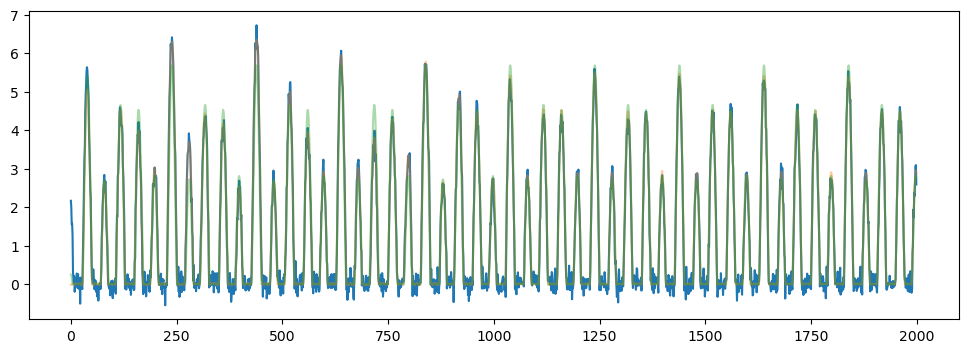

In [13]:
i=18 #15
shift=1000
plt.figure(figsize=(12,4))
plt.plot(data_te.iloc[i,:])
plt.plot(yGPm.iloc[i,:],alpha=0.4)
plt.plot(dNN.iloc[i,:],alpha=0.4)
df = data_te-dNN #error
df1 = data_te-yGPm #error
print(np.sqrt((np.mean(df.values[i,shift:]**2))))

print(np.sqrt(np.mean(df1.values[i,shift:]**2)))




In [250]:
data[i][0]

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.0000e-02, 9.4108e-02, 1.5643e-01],
         [2.0000e-02, 1.8738e-01, 3.0902e-01],
         ...,
         [1.4970e+01, 2.7899e-01, 4.5399e-01],
         [1.4980e+01, 1.8738e-01, 3.0902e-01],
         [1.4990e+01, 9.4108e-02, 1.5643e-01]]], dtype=torch.float64)

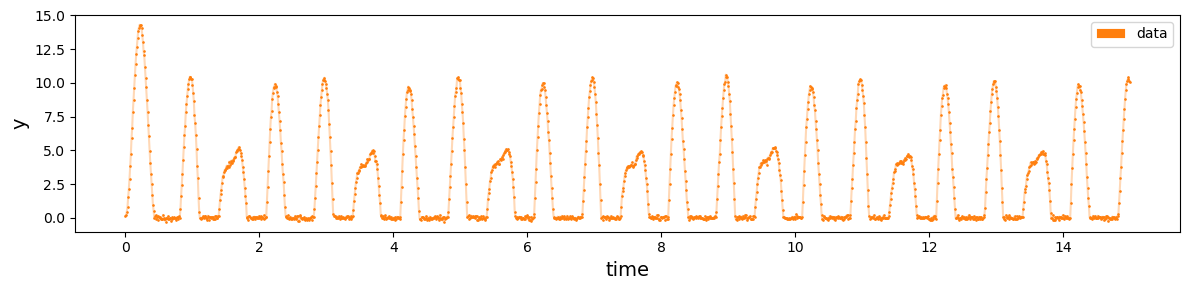

In [20]:
t_tr=data[i][0][0,:,0].numpy()
y_tr=data[i][1].numpy()
fig,ax=plt.subplots(figsize=(12,3))
ax.scatter(t_tr.flatten(),y_tr.flatten(),color='C1',s=0.8,zorder=1e6,label="data")
plt.plot(t_tr.flatten(),y_tr.flatten(),color='C1',alpha=0.3)
plt.legend()
plt.ylabel("y",fontsize=14)
plt.xlabel("time",fontsize=14)
#ax.axvline(time_tr[-1],color='black')
r_patch = mpatches.Patch(color='C1', label='data',linewidth=0.1)
plt.legend(handles=[r_patch])
plt.tight_layout()
plt.savefig("data_linear.pdf")

In [252]:
time_tep.shape

(2000,)

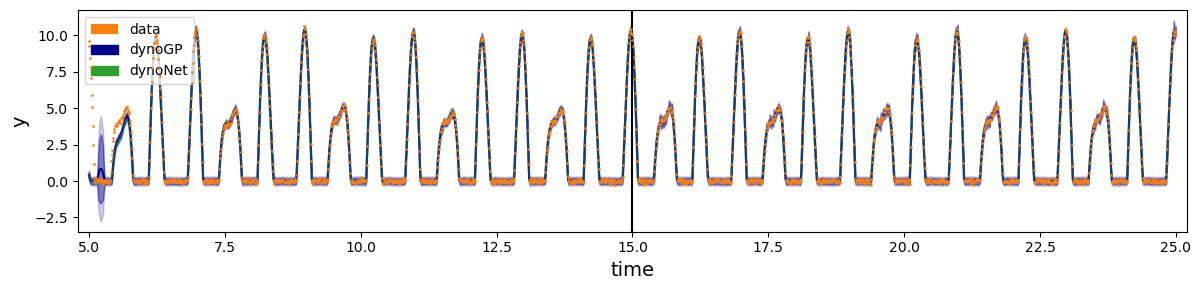

In [21]:
time_tep = data[i][2][0,:,0].numpy()
y_te = data[i][3].numpy()
predictive_means= dGP_means[i]
predictive_variances = dGP_vars[i]
fig,ax=plt.subplots(figsize=(12,3))
ax.scatter(time_tep.flatten(),y_te.flatten(),color='C1',s=0.8,zorder=1e6,label="data")
#meanp = predictive_means.mean(axis=0).flatten()
samples=[]
nsamples=10000
for ii in range(nsamples):
    j = np.random.randint(predictive_means.shape[0])
    s = predictive_means[j,0,:]+np.sqrt(predictive_variances[j,0,:])*np.random.randn(predictive_variances.shape[2])
    samples.append(s)
samples = np.vstack(samples)
import arviz
ci = arviz.hdi(samples[None,:],hdi_prob=0.95)
#plot_gp_dist(ax,samples,time_tep.flatten(),samples_alpha=0.3,palette='Blues',label=None)
ax.plot(time_tep.flatten(),np.median(predictive_means,axis=1).flatten(),'darkblue')
#plot_gp_dist(ax,samples,time_tep.flatten(),samples_alpha=0.3,palette='Blues',label=None)
ax.fill_between(time_tep.flatten(),ci[:,0],ci[:,1], alpha=0.4,color='darkblue')
ci = arviz.hdi(samples[None,:],hdi_prob=0.997)
ax.fill_between(time_tep.flatten(),ci[:,0],ci[:,1], alpha=0.2,color='darkblue')
#plot_gp_dist(ax,predictive_means[:,0,:],time_tep.flatten(),samples_alpha=0.01,palette='Blues',label=None)
plt.plot(time_tep.flatten(),dNN.iloc[i,:],alpha=0.4,color='C2',label='dynoNet')
ax.axvline(t_tr[-1],color='black')
ax.set_ylabel("y",fontsize=14)
ax.set_xlabel("time",fontsize=14)
ax.set_xlim([4.8,25.2])
r_patch = mpatches.Patch(color='C1', label='data',linewidth=0.1)
b_patch = mpatches.Patch(color='darkblue', label='dynoGP')
c_patch = mpatches.Patch(color='C2', label='dynoNet')
plt.legend(handles=[r_patch,b_patch,c_patch],loc= 'upper left')
#plt.legend(handles=[r_patch,b_patch],loc= 'upper left')
plt.tight_layout()
plt.savefig("gp_x2.pdf")

# Error

In [219]:
df.shape

(44, 2000)

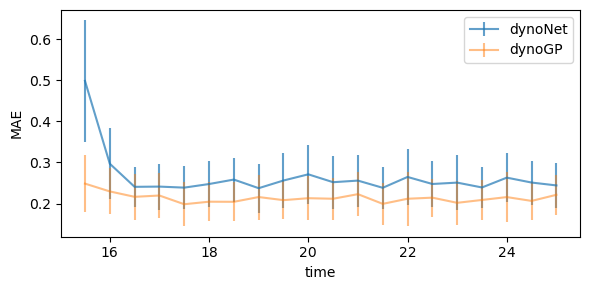

In [257]:
def eliminate_outlier_mae(array1, array2, n=3):

    if len(array1) != len(array2):
        raise ValueError("Both arrays must have the same length.")
    
    # Combine the two arrays to determine the indices of the worst MAE values
    combined_mae = np.maximum(array1, array2)
    
    # Get the indices of the `n` largest MAE values
    worst_indices = np.argsort(combined_mae)[-n:]
    
    # Create masks to exclude the worst indices
    mask = np.ones(len(array1), dtype=bool)
    mask[worst_indices] = False
    
    # Return filtered arrays
    return mask
    
shift=950
window=50
inds = eliminate_outlier_mae(abs(df.iloc[:,shift:]).mean(axis=1),abs(df1.iloc[:,shift:]).mean(axis=1),n=3)
RMSE_NN_med = (abs(df.loc[inds].iloc[:,shift:]).median(axis=0).rolling(window,step=window).mean())
RMSE_GP_med = (abs(df1.loc[inds].iloc[:,shift:]).median(axis=0).rolling(window,step=window).mean())
RMSE_NN_std = (abs(df.loc[inds].iloc[:,shift:]).median(axis=0).rolling(window,step=window).std()) #quantile(0.75))(abs(df.loc[inds].iloc[:,shift:]).median(axis=0).rolling(window,step=window).quantile(0.25))
RMSE_GP_std = (abs(df1.loc[inds].iloc[:,shift:]).median(axis=0).rolling(window,step=window).std()) #quantile(0.75))-(abs(df1.loc[inds].iloc[:,shift:]).median(axis=0).rolling(window,step=window).quantile(0.25))

plt.figure(figsize=(6,3))
plt.errorbar(np.linspace(15,25,len(RMSE_NN_med)),RMSE_NN_med,RMSE_NN_std,label="dynoNet",alpha=0.7)
plt.errorbar(np.linspace(15,25,len(RMSE_NN_med)),RMSE_GP_med,RMSE_GP_std,label="dynoGP",alpha=0.5)
#plt.title('MAE on the test set')
plt.xlabel('time')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.savefig("Wiener_MAE.pdf")

In [215]:
inds

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True])

In [15]:
df1.shape

(47, 2000)

In [16]:
window = 100
rmse = []
for y_hat in [test_y_hat_GP,test_y_hat_NN]:
    rmse=  rmse + [(pd.DataFrame(abs(y_hat-test_y)**2).rolling(window,step=window).mean()) **0.5]
    plt.figure()
plt.plot(rmse[0],label='GP')
plt.plot(rmse[1],label='NN')
plt.title("RMSE - avergaed on on chunks of 100 ys")
plt.ylabel("RMSE",fontsize=16)
plt.xlabel("time",fontsize=16)
plt.axvline(shiftp,color='k')
plt.legend()
#plt.savefig(folder+"RMSE.png")

NameError: name 'test_y_hat_GP' is not defined